# CS 7643 Assignment 2 Part 1:  Implement and train a network on CIFAR-10

Convolutional Neural Networks (CNNs) are one of the major advancements in
computer vision over the past decade. In this assignment, you will complete
a simple CNN architecture from scratch and learn how to implement CNNs
with PyTorch, one of the most commonly used deep learning frameworks.
You will also run different experiments on imbalanced datasets to evaluate
your model and techniques to deal with imbalanced data.

### Load Extensions
Before getting started we need to run some standard code to set up our environment. You'll need to execute this code again each time you start the notebook.

First, run this cell to load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This enables us to modify `.py` source files and reintegrate them into the notebook, ensuring a smooth editing and debugging experience.


In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!).

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Now remember the path in your Google Drive where you uploaded this notebook, fill it in below. If all functions properly, executing the next cell should display the filenames from the assignment:

```
['CS7643-Assignment2-1.ipynb', 'cs7643', 'data', 'configs', 'models', 'optimizer', 'tests']
```

In [ ]:
# import os

# # TODO: Fill in the Google Drive path where you uploaded assignment1
# # Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
# GOOGLE_DRIVE_PATH_POST_MYDRIVE = None
# GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))

In [ ]:
# import sys

# sys.path.append(GOOGLE_DRIVE_PATH)

### Local Setup OR Google Drive
Run the cell below regardless of whether you are using google drive or local setup.

In [2]:
# if running locally set GOOGLE PATH
import sys
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')

Running locally.


After successfully identifying the path to this assignment, execute the following cell to enable us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Roger that from conv_classifier.py!
Roger that from softmax_ce.py!
Roger that from linear.py!
Roger that from relu.py!
Roger that from max_pool.py!
Roger that from convolution.py!

Roger that from _base_optimizer.py!
Roger that from sgd.py!
```

as well as the last edit time for the files `_conv_classifier.py`, `convolution.py`, `linear.py`, `max_pool.py`, `relu.py`, `softmax_ce.py`, `_base_optimizer.py`, and `sgd.py`. You may have to try running the cell twice if the first time fails.

In [4]:
import numpy as np
import math

from cs7643.env_prob import say_hello_do_you_copy

say_hello_do_you_copy(GOOGLE_DRIVE_PATH)


---------- Modules ------------------
Roger that from conv_classifier.py!
Roger that from softmax_ce.py!
Roger that from linear.py!
Roger that from relu.py!
Roger that from max_pool.py!
Roger that from convolution.py!
conv_classifier.py last edited on Wed Sep 18 06:06:37 2024
softmax_ce.py last edited on Wed Sep 18 03:15:06 2024
linear.py last edited on Wed Sep 18 09:30:04 2024
relu.py last edited on Wed Sep 18 03:15:06 2024
max_pool.py last edited on Thu Sep 19 13:47:14 2024
convolution.py last edited on Thu Sep 19 13:31:42 2024

---------- Optimizer ------------------
Roger that from _base_optimizer.py!
Roger that from sgd.py!
_base_optimizer.py last edited on Wed Sep 18 03:15:06 2024
sgd.py last edited on Thu Sep 19 13:47:30 2024


[autoreload of cs7643.utils failed: Traceback (most recent call last):
  File "C:\Users\mccar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\mccar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1776.0_x64__qbz5n2kfra8p0\Lib\importlib\__init__.py", line 121, in reload
    raise ImportError(f"parent {parent_name!r} not in sys.modules",
ImportError: parent 'cs7643' not in sys.modules
]
[autoreload of cs7643.env_prob failed: Traceback (most recent call last):
  File "C:\Users\mccar\AppData\Local\Packages\PythonSoftwareFoundation.Pyth

# Load the CIFAR10 dataset
Data loading is the very first step of any machine learning pipelines. Run the following cell to download the CIFAR10 dataset.

In [5]:
from cs7643.cifar10 import CIFAR10

train_ds = CIFAR10(GOOGLE_DRIVE_PATH + '/data/cifar10', download=True, train=True)
test_ds = CIFAR10(GOOGLE_DRIVE_PATH + '/data/cifar10', download=True, train=False)

100%|██████████| 170498071/170498071 [02:19<00:00, 1223048.05it/s]


Extracting ./data/cifar10\cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


# Implementing CNN from Scratch
You will work in `./part1-convnet` for this part of the assignment. **Note that
vectorization is not a requirement for this part of the assignment**.

## Module Implementation
You will now learn how to build CNN from scratch. Typically, a convolutional
neural network is composed of several different modules and these modules
work together to make the network effective. For each module, you will
implement a forward pass (computing forwarding results) and a backward
pass (computing gradients). Therefore, your tasks are as follows:

Follow the instructions in the code to complete each module in `./modules`. Specifically, modules to be implemented are 2D convolution, 2D
Max Pooling, ReLU, and Linear. These will be the building blocks of
the full network. The file `./modules/conv_classifier.py` ties each of the
aforementioned modules together and is the subject of the next section. Run the following cells to test your implementations.

In [11]:
#Let's test your implementation of Linear
!pytest -s {GOOGLE_DRIVE_PATH.replace(' ', '\ ') + '/tests/test_linear.py'}

<string>:1: SyntaxWarning: invalid escape sequence '\ '


============================= test session starts =============================
platform win32 -- Python 3.12.6, pytest-8.3.3, pluggy-1.5.0
rootdir: c:\Users\mccar\georgia_tech\deep_learning\2_assign\assignment2\part1-convnet
plugins: anyio-4.5.0
collected 2 items

tests\test_linear.py ..

============================== 2 passed in 0.15s ==============================


In [13]:
#Let's test your implementation of Max Pooling
!pytest -s {GOOGLE_DRIVE_PATH.replace(' ', '\ ') + '/tests/test_maxpool.py'}

<string>:1: SyntaxWarning: invalid escape sequence '\ '


============================= test session starts =============================
platform win32 -- Python 3.12.6, pytest-8.3.3, pluggy-1.5.0
rootdir: c:\Users\mccar\georgia_tech\deep_learning\2_assign\assignment2\part1-convnet
plugins: anyio-4.5.0
collected 2 items

tests\test_maxpool.py ..

============================== 2 passed in 0.43s ==============================


In [14]:
#Let's test your implementation of RELU
!pytest -s {GOOGLE_DRIVE_PATH.replace(' ', '\ ') + '/tests/test_relu.py'}

<string>:1: SyntaxWarning: invalid escape sequence '\ '


============================= test session starts =============================
platform win32 -- Python 3.12.6, pytest-8.3.3, pluggy-1.5.0
rootdir: c:\Users\mccar\georgia_tech\deep_learning\2_assign\assignment2\part1-convnet
plugins: anyio-4.5.0
collected 2 items

tests\test_relu.py ..

============================== 2 passed in 0.13s ==============================


In [15]:
#Let's test your implementation of Conv2D
!pytest -s {GOOGLE_DRIVE_PATH.replace(' ', '\ ') + '/tests/test_conv.py'}

<string>:1: SyntaxWarning: invalid escape sequence '\ '


============================= test session starts =============================
platform win32 -- Python 3.12.6, pytest-8.3.3, pluggy-1.5.0
rootdir: c:\Users\mccar\georgia_tech\deep_learning\2_assign\assignment2\part1-convnet
plugins: anyio-4.5.0
collected 2 items

tests\test_conv.py ..

============================== 2 passed in 0.35s ==============================


## Network Implementation
After finishing each module, it's time to put things together to form a real
convolutional neural network.

Follow the instructions in the code to complete a CNN network in `./modules/conv_classifier.py`. The network is constructed by a list of module definitions in order and should handle both forward and backward communication between modules.

# Optimizer
You have implemented a simple SGD optimizer in assignment-1. In practice, it is common to use a momentum term in SGD for better convergence. Specifically, we introduce a new velocity term $v_t$ and the update rule is as follows:

$$
v_t = \beta v_{t-1} - \eta \frac{\partial L}{\partial w} \\
w = w + v_t
$$

where $\beta$ denotes the momentum coefficient and $\eta$ denotes the learning rate.

Follow the instructions in the code to complete SGD with momentum
in `./optimizer/sgd.py`. **Hint**: you will need to store and use the velocity
from the previous iteration of SGD to compute the new gradient for
the current iteration. Feel free to add member variable(s) to achieve
this.

In [17]:
# Test your SGD implementation
!pytest -s {GOOGLE_DRIVE_PATH.replace(' ', '\ ') + '/tests/test_sgd.py'}

<string>:1: SyntaxWarning: invalid escape sequence '\ '


============================= test session starts =============================
platform win32 -- Python 3.12.6, pytest-8.3.3, pluggy-1.5.0
rootdir: c:\Users\mccar\georgia_tech\deep_learning\2_assign\assignment2\part1-convnet
plugins: anyio-4.5.0
collected 1 item

tests\test_sgd.py .

============================== 1 passed in 0.13s ==============================


# Experiments
Now, you have completed coding the entire training process. It’s time to play with your model a little. If you're already attempted to train your implementation, you might have noticed that it is extremely slow. Therefore, we only want to deliberately overfit the model with a small portion of data to verify whether the model is learning something or not.

You will train a small CNN with only 50 samples in CIFAR-10 dataset. The script will make a plot on the training data only and **be sure to include the plot in your report**. Your final accuracy should be slightly under `0.9` with the given network in the script. To start the training, execute the next cell.

Number of training samples 49000
Finished epoch 0 / 10: cost 2.306153, train: 0.180000, lr 1.000000e-04
Finished epoch 1 / 10: cost 2.251948, train: 0.320000, lr 9.500000e-05
Finished epoch 2 / 10: cost 2.159310, train: 0.380000, lr 9.025000e-05
Finished epoch 3 / 10: cost 1.805048, train: 0.340000, lr 8.573750e-05
Finished epoch 4 / 10: cost 1.545141, train: 0.460000, lr 8.145062e-05
Finished epoch 5 / 10: cost 1.097030, train: 0.680000, lr 7.737809e-05
Finished epoch 6 / 10: cost 0.666996, train: 0.760000, lr 7.350919e-05
Finished epoch 7 / 10: cost 1.318808, train: 0.780000, lr 6.983373e-05
Finished epoch 8 / 10: cost 0.306557, train: 0.860000, lr 6.634204e-05
Finished epoch 9 / 10: cost 0.097204, train: 0.920000, lr 6.302494e-05
Finished epoch 10 / 10: cost 0.614703, train: 0.880000, lr 5.987369e-05


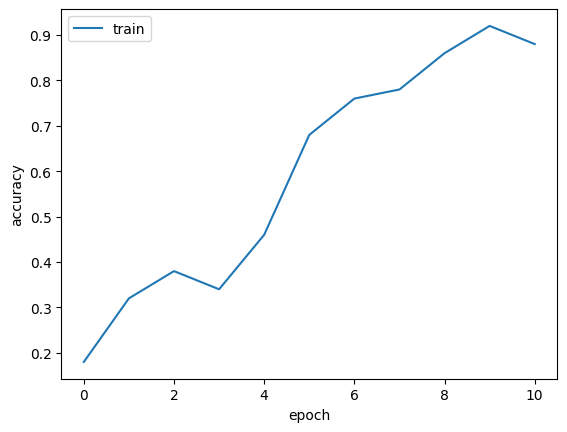

In [19]:
import matplotlib.pyplot as plt

from modules import ConvNet
from optimizer import SGD
from cs7643.solver import Solver
from data import get_CIFAR10_data

root = GOOGLE_DRIVE_PATH + '/data/cifar10/cifar-10-batches-py'
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(root)

print(f'Number of training samples {len(X_train)}')

model_list = [dict(type='Conv2D', in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
              dict(type='ReLU'),
              dict(type='MaxPooling', kernel_size=2, stride=2),
              dict(type='Linear', in_dim=8192, out_dim=10)]
criterion = dict(type='SoftmaxCrossEntropy')
model = ConvNet(model_list, criterion)
optimizer = SGD(model, learning_rate=0.0001, reg=0.001, momentum=0.9)

trainer = Solver()

loss_history, train_acc_history = trainer.train(
    X_train[:50], y_train[:50], model, batch_size=10, num_epochs=10,
    verbose=True, optimizer=optimizer
    )

plt.plot(train_acc_history)
plt.legend(['train'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig(GOOGLE_DRIVE_PATH + '/train.png')

# Submit Your Work
After completing the notebook for this assignment (`assignment2_1.ipynb`), run the following cell to create a `.zip` file for you to download and to upload to Gradescope.

**Please MANUALLY SAVE `*.py` files before executing the following cell:**

In [20]:
from cs7643.submit import make_a2_1_submission

make_a2_1_submission(GOOGLE_DRIVE_PATH)

Writing zip file to:  .\assignment_2_1_submission.zip
